In [1]:
%load_ext line_profiler

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

In [3]:
import warnings
warnings.filterwarnings('default')

In [5]:
with open('save/records','rb') as f:
    records = pickle.load(f)

In [7]:
with open('save/lifespans','rb') as f:
    lifespans = pickle.load(f)

In [9]:
with open('save/plt_ag', 'rb') as f:
    plt_ag = pickle.load(f)

In [10]:
with open('save/plt_agl','rb') as f:
    plt_agl = pickle.load(f)

In [11]:
with open('save/plt_ucbl','rb') as f:
    plt_ucbl = pickle.load(f)

(array([  3.,   1.,  10.,  15.,  10.,  17.,  22.,  11.,   7.,   4.]),
 array([ 4341. ,  4368.5,  4396. ,  4423.5,  4451. ,  4478.5,  4506. ,
         4533.5,  4561. ,  4588.5,  4616. ]),
 <a list of 10 Patch objects>)

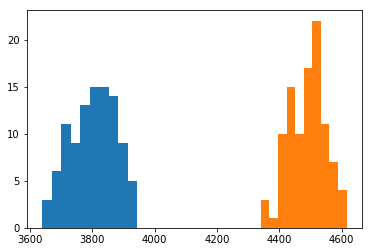

In [12]:
plt.hist(plt_ag)
plt.hist(plt_agl)

In [5]:
records = pd.concat([pd.read_csv('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i), 
                                 sep=' ',
                                 names=['timestamp','id','clicked'],
                                 usecols=[0,1,2],) for i in range(2,17)])

In [8]:
lifespans = {}
for i in range(2,17):
    with open('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i)) as f:
        for line in f.readlines():
            timestamp = int(line[:10])
            components = line.strip().split(' |')
            for article in components[2:]:
                if article in lifespans:
                    lifespans[article][1] = timestamp
                else:
                    lifespans[article] = [timestamp, timestamp]

In [6]:
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [7]:
len(records)

27777695

In [19]:
records.clicked.value_counts()

0    26749863
1     1027832
Name: clicked, dtype: int64

In [24]:
len(records.id.value_counts()), len(lifespans)

(652, 652)

In [26]:
records.timestamp

0          1317513291
1          1317513291
2          1317513291
3          1317513292
4          1317513292
5          1317513292
6          1317513292
7          1317513293
8          1317513293
9          1317513293
10         1317513293
11         1317513293
12         1317513293
13         1317513293
14         1317513293
15         1317513293
16         1317513293
17         1317513293
18         1317513293
19         1317513293
20         1317513293
21         1317513293
22         1317513293
23         1317513293
24         1317513294
25         1317513294
26         1317513294
27         1317513294
28         1317513294
29         1317513294
              ...    
1292208    1318809292
1292209    1318809292
1292210    1318809292
1292211    1318809292
1292212    1318809292
1292213    1318809292
1292214    1318809292
1292215    1318809292
1292216    1318809292
1292217    1318809292
1292218    1318809292
1292219    1318809292
1292220    1318809292
1292221    1318809292
1292222   

In [10]:
with open('save/records','wb') as f:
    pickle.dump(records, f)

In [9]:
with open('save/lifespans', 'wb') as f:
    pickle.dump(lifespans, f)

In [13]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        #self.s = None
        #self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True))

In [14]:
unborn

['id-615546',
 'id-615454',
 'id-615333',
 'id-615415',
 'id-615270',
 'id-610503',
 'id-611679',
 'id-615207',
 'id-615223',
 'id-615053',
 'id-610521',
 'id-611774',
 'id-615038',
 'id-614798',
 'id-614746',
 'id-614718',
 'id-614078',
 'id-614695',
 'id-606514',
 'id-608633',
 'id-614499',
 'id-614506',
 'id-614508',
 'id-614126',
 'id-614149',
 'id-614153',
 'id-614050',
 'id-614010',
 'id-611851',
 'id-614016',
 'id-614024',
 'id-613856',
 'id-613912',
 'id-612378',
 'id-613765',
 'id-600025',
 'id-613786',
 'id-613546',
 'id-613675',
 'id-613689',
 'id-613505',
 'id-613449',
 'id-606079',
 'id-610758',
 'id-611585',
 'id-611078',
 'id-611110',
 'id-612506',
 'id-613404',
 'id-612461',
 'id-613241',
 'id-613242',
 'id-596821',
 'id-605423',
 'id-613111',
 'id-610351',
 'id-606207',
 'id-612994',
 'id-611775',
 'id-612272',
 'id-611932',
 'id-611864',
 'id-611740',
 'id-611729',
 'id-611429',
 'id-610484',
 'id-611597',
 'id-611479',
 'id-611482',
 'id-611142',
 'id-610505',
 'id-6

In [15]:
pool

{'id-552077': -1.0000 0/0 lifespan: (1317513291, 1317515399),
 'id-555224': -1.0000 0/0 lifespan: (1317513291, 1317588299),
 'id-555528': -1.0000 0/0 lifespan: (1317513291, 1317587099),
 'id-559744': -1.0000 0/0 lifespan: (1317513291, 1317515699),
 'id-559855': -1.0000 0/0 lifespan: (1317513291, 1317587099),
 'id-560290': -1.0000 0/0 lifespan: (1317513291, 1317587099),
 'id-560518': -1.0000 0/0 lifespan: (1317513291, 1317578399),
 'id-560620': -1.0000 0/0 lifespan: (1317513291, 1317521099),
 'id-563115': -1.0000 0/0 lifespan: (1317513291, 1317581999),
 'id-563582': -1.0000 0/0 lifespan: (1317513291, 1317583799),
 'id-563643': -1.0000 0/0 lifespan: (1317513291, 1317636599),
 'id-563787': -1.0000 0/0 lifespan: (1317513291, 1317515699),
 'id-563846': -1.0000 0/0 lifespan: (1317513291, 1317636599),
 'id-563938': -1.0000 0/0 lifespan: (1317513291, 1317519299),
 'id-564335': -1.0000 0/0 lifespan: (1317513291, 1317571199),
 'id-564418': -1.0000 0/0 lifespan: (1317513291, 1317636599),
 'id-564

In [16]:
len(pool)

652

In [17]:
class AG_L:
    def __init__(self, records, pool, unborn):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = []
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.n_exploit = 0
        self.best = 'id-563643'
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def filter_live(self):
        '''
        edit list of currently available arms
        '''
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(self.time)
        self.alive = self.alive[ index : ]
        # pop new born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
        
    def initialize(self, m):
        for i in range(m):
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live()
            if not pool[record.id].T: # not played
                self.update(record)
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live()
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = 1
                else: #explore
                    pick = random.choice(self.alive[int((1-threshold)*len(self.alive)) : ])
                    exploited = 0
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [163]:
%lprun -f agl.play agl.play(1000)

In [30]:
%%timeit
agl = AG_L(records, pool, unborn)
agl.initialize(25)
agl.play(975,.1)

2.9 s ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
class UCB_L:
    def __init__(self, records, pool, unborn):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        #self.avg_life = 0
        self.X = 0
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        n_seen = len(self.pool) - len(self.unborn)
        self.X = (self.X * (n_seen-1) + record.clicked) / n_seen
    
    def filter_live(self, t):  
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            #self.pool[arm].s = t
            heapq.heappush(self.alive, (self.pool[arm].death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < self.time:
                heapq.heappop(self.alive)
                '''
                dying = self.pool[arm]
                dying.l = t
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
                self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead
                '''
            else:
                break
        return
                
    def initialize(self, m):
        self.m = m
        for self.t in range(m):
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live(self.t)
            if not pool[record.id].T: # not played
                self.update(record)
    
    def play(self, n, c=.008):
        def score(heap_tuple):
            r = self.t / (self.time - 1317513291)
            arm = self.pool[heap_tuple[1]]
            if arm.T:
                T = arm.T
                X = arm.X
            else: # if it's never played, use estimation
                T = 1
                X = self.X
            if c:
                return X + c*np.log(r*(arm.death - self.time) + 1) * np.sqrt( 2*np.log(r*(self.time - arm.birth) + 1)/T)
            else:
                return X + np.sqrt( 2*np.log(r*(self.time - arm.birth) + 1)/T)
            '''
            if not self.avg_life:
                return X
            try:
                return X + c*np.log(self.avg_life+arm.s-t+1) * np.sqrt(2*np.log(t - arm.s+1)/T)
            except RuntimeWarning:
                #print(self.avg_life, arm.s, t)
                return X
                '''
        self.n = n
        for self.t in range(self.m, n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live(self.t)
                pick = max(self.alive, key=score)[1]
                if pick == record.id:
                    self.update(record)
                    break

In [88]:
ucbl = UCB_L(records, pool, unborn)
ucbl.initialize(25)
ucbl.play(1000,.008)

In [89]:
ucbl.rewards

41

In [105]:
# AG
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, 1)
    end = time.time()
    print('player',i,'finished with',agl.rewards,'time spent:', end-start)
    return agl.rewards
plt_ag = []
with Pool(4) as p:
    plt_ag += p.map(player_ag, [i for i in range(100)])

player 0 started
player 7 started
player 21 started
player 14 started
player 21 finished with 3848 time spent: 16.869277238845825
player 0 finished with 3809 time spent: 17.337093591690063
player 22 started
player 7 finished with 3879 time spent: 17.99132251739502
player 1 started
player 14 finished with 3832 time spent: 18.41372537612915
player 8 started
player 15 started
player 22 finished with 3839 time spent: 17.60358428955078
player 1 finished with 3710 time spent: 17.683621644973755
player 8 finished with 3891 time spent: 17.221111536026
player 23 started
player 2 started
player 9 started
player 15 finished with 3940 time spent: 18.23388171195984
player 16 started
player 2 finished with 3901 time spent: 16.132309675216675
player 3 started
player 23 finished with 3763 time spent: 18.419862508773804
player 9 finished with 3857 time spent: 18.41916012763977
player 16 finished with 3799 time spent: 17.275121927261353
player 24 started
player 10 started
player 17 started
player 3 fini

In [110]:
with open('save/plt_ag', 'wb') as f:
    pickle.dump(plt_ag,f)

In [106]:
sum(plt_ag)

380209

(array([  3.,   6.,  11.,   9.,  13.,  15.,  15.,  14.,   9.,   5.]),
 array([ 3639. ,  3669.5,  3700. ,  3730.5,  3761. ,  3791.5,  3822. ,
         3852.5,  3883. ,  3913.5,  3944. ]),
 <a list of 10 Patch objects>)

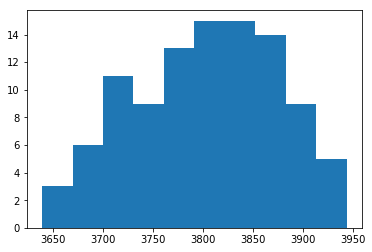

In [107]:
plt.hist(plt_ag)

In [102]:
# AG_L with threshold .3
def player_ag(i):
    print('player',i,'started')
    start = time.time()
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, .3)
    end = time.time()
    print('player',i,'finished with',agl.rewards,'time spent:', end-start)
    return agl.rewards
plt_agl = []
with Pool(4) as p:
    plt_agl += p.map(player_ag, [i for i in range(100)])

player 0 started
player 21 started
player 7 started
player 14 started
player 0 finished with 4413 time spent: 16.234094381332397
player 1 started
player 14 finished with 4527 time spent: 17.87995719909668
player 21 finished with 4544 time spent: 18.44281005859375
player 7 finished with 4499 time spent: 18.716455698013306
player 15 started
player 22 started
player 8 started
player 1 finished with 4514 time spent: 16.173981428146362
player 2 started
player 15 finished with 4375 time spent: 16.590834617614746
player 16 started
player 22 finished with 4442 time spent: 18.121007442474365
player 8 finished with 4509 time spent: 18.451669454574585
player 23 started
player 9 started
player 2 finished with 4548 time spent: 16.9971022605896
player 3 started
player 16 finished with 4529 time spent: 17.644106149673462
player 17 started
player 9 finished with 4529 time spent: 17.349998235702515
player 23 finished with 4425 time spent: 18.472824573516846
player 10 started
player 24 started
player 3 

In [109]:
with open('save/plt_agl', 'wb') as f:
    pickle.dump(plt_agl,f)

In [104]:
sum(plt_agl)

448938

(array([  3.,   1.,  10.,  15.,  10.,  17.,  22.,  11.,   7.,   4.]),
 array([ 4341. ,  4368.5,  4396. ,  4423.5,  4451. ,  4478.5,  4506. ,
         4533.5,  4561. ,  4588.5,  4616. ]),
 <a list of 10 Patch objects>)

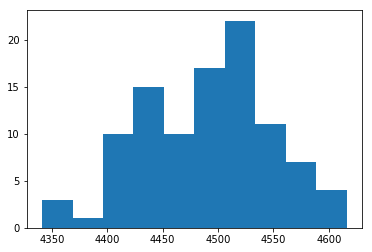

In [103]:
plt.hist(plt_agl)

In [ ]:
# UCB
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, None)
    end = time.time()
    print('player',i,'finished with',ucbl.rewards,'time spent:', end-start)
    return ucbl.rewards
plt_ucb = []
with Pool(4) as p:
    plt_ucb += p.map(player, [i for i in range(100)])

player 0 started
player 7 started
player 14 started
player 21 started
player 7 finished with 4975 time spent: 249.27287340164185
player 8 started
player 0 finished with 5089 time spent: 254.7397346496582
player 1 started
player 21 finished with 4984 time spent: 257.4602737426758
player 22 started
player 14 finished with 5021 time spent: 260.5403661727905
player 15 started
player 8 finished with 5115 time spent: 247.4555721282959
player 9 started
player 1 finished with 5141 time spent: 243.00802731513977
player 2 started
player 15 finished with 4986 time spent: 252.06686520576477
player 16 started
player 22 finished with 5017 time spent: 261.1441423892975
player 23 started
player 9 finished with 4923 time spent: 246.976007938385
player 10 started
player 2 finished with 5041 time spent: 248.8414101600647
player 3 started
player 16 finished with 5080 time spent: 249.39880681037903
player 17 started
player 23 finished with 5044 time spent: 258.78422021865845
player 24 started
player 10 fin

In [95]:
# UCB_L
def player(i):
    print('player',i,'started')
    start = time.time()
    ucbl = UCB_L(records[i*10000:], pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, .008)
    end = time.time()
    print('player',i,'finished with',ucbl.rewards,'time spent:', end-start)
    return ucbl.rewards
plt_ucbl = []
with Pool(4) as p:
    plt_ucbl += p.map(player, [i for i in range(100)])

player 21 started
player 7 started
player 14 started
player 0 started
player 0 finished with 7074 time spent: 322.397803068161
player 1 started
player 7 finished with 7000 time spent: 324.9970381259918
player 8 started
player 14 finished with 7224 time spent: 326.27226638793945
player 15 started
player 21 finished with 7197 time spent: 342.5057272911072
player 22 started
player 1 finished with 7070 time spent: 320.66729068756104
player 2 started
player 8 finished with 7120 time spent: 331.26680278778076
player 9 started
player 15 finished with 7066 time spent: 331.1915776729584
player 16 started
player 22 finished with 7174 time spent: 343.2067861557007
player 23 started
player 2 finished with 7034 time spent: 317.6798448562622
player 3 started
player 16 finished with 7146 time spent: 326.44353127479553
player 17 started
player 9 finished with 7198 time spent: 330.6844735145569
player 10 started
player 23 finished with 7103 time spent: 340.11647391319275
player 24 started
player 3 fini

In [108]:
with open('save/plt_ucbl', 'wb') as f:
    pickle.dump(plt_ucbl,f)

In [98]:
sum(plt_ucbl)

786927

(array([ 18.,  15.,  11.,   9.,   7.,   5.,   5.,   9.,   9.,  12.]),
 array([ 6978. ,  7181.5,  7385. ,  7588.5,  7792. ,  7995.5,  8199. ,
         8402.5,  8606. ,  8809.5,  9013. ]),
 <a list of 10 Patch objects>)

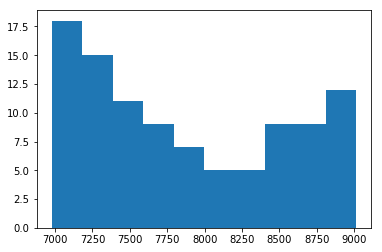

In [97]:
plt.hist(plt_ucbl)

(array([ 1.,  2., 10., 13., 18.,  7., 18., 14., 13.,  4.]),
 array([4319. , 4385.3, 4451.6, 4517.9, 4584.2, 4650.5, 4716.8, 4783.1,
        4849.4, 4915.7, 4982. ]),
 <a list of 10 Patch objects>)

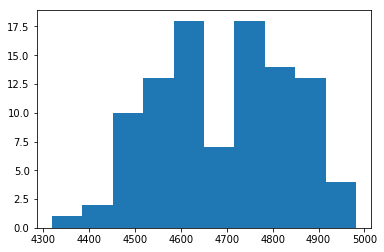

In [179]:
def play(records):
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, .3)
    return agl.rewards
plt_agl = []
for j in range(25):
    print(j, end='\r', flush=True)
    with Pool(4) as p:
        plt_agl += p.map(play, [records[(i+4*j)*10000:] for i in range(4)])
plt.hist(plt_agl)

In [ ]:
players = Counter()
for line in txt.split('\n'):
    words = line.split(' ')
    if words[2]=='started':
        players[words[1]] += 1
    else:
        players[words[1]] -= 1

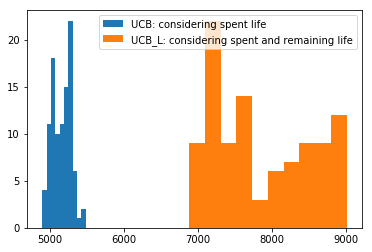

In [176]:
plt.hist(plt_ucb, bins=10, label='UCB: considering spent life')
plt.hist(plt_ucbl, bins=10, label='UCB_L: considering spent and remaining life')
plt.legend()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


(array([ 4., 11., 18., 10., 11., 15., 22.,  6.,  1.,  2.]),
 array([4892., 4951., 5010., 5069., 5128., 5187., 5246., 5305., 5364.,
        5423., 5482.]),
 <a list of 10 Patch objects>)

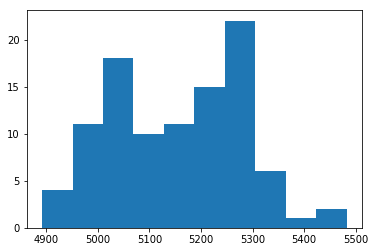

In [170]:
def play(records):
    ucb = UCB_L(records, pool, unborn)
    ucb.initialize(25)
    ucb.play(100000, c=None)
    return ucb.rewards
plt_ucb = []
for j in range(25):
    print(j, , end='\r', flush=True)
    with Pool(4) as p:
        plt_ucb += p.map(play, [records[(i+4*j)*10000:] for i in range(4)])
plt.hist(plt_ucb)

(array([ 6.,  6., 21., 24., 20., 14.,  3.,  4.,  1.,  1.]),
 array([4365. , 4400.9, 4436.8, 4472.7, 4508.6, 4544.5, 4580.4, 4616.3,
        4652.2, 4688.1, 4724. ]),
 <a list of 10 Patch objects>)

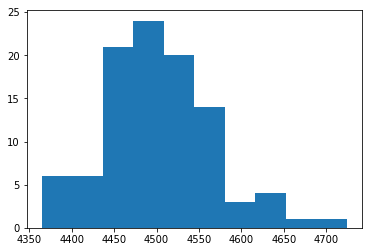

In [167]:
def play(args):
    records, pool = args
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, .3)
    return agl.rewards
plt_agl = []
with Pool(4) as p:
    plt_agl += p.map(play, [(records, pool) for _ in range(100)])
plt.hist(plt_agl)

(array([ 6.,  9., 10., 13., 19., 12., 12., 11.,  3.,  5.]),
 array([4404. , 4429.3, 4454.6, 4479.9, 4505.2, 4530.5, 4555.8, 4581.1,
        4606.4, 4631.7, 4657. ]),
 <a list of 10 Patch objects>)

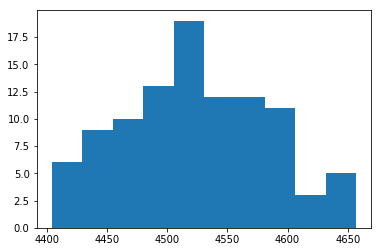

In [64]:
res = []
with Pool(4) as p:
    res = p.map(play, [(records, pool) for _ in range(100)])
plt.hist(res)

(array([ 4., 10., 15., 20., 25.,  6., 14.,  5.,  0.,  1.]),
 array([3664. , 3698.5, 3733. , 3767.5, 3802. , 3836.5, 3871. , 3905.5,
        3940. , 3974.5, 4009. ]),
 <a list of 10 Patch objects>)

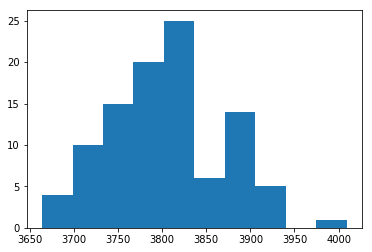

In [75]:
def play(args):
    records, pool = args
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, 1)
    return agl.rewards
ag = []
with Pool(4) as p:
    ag = p.map(play, [(records, pool) for _ in range(100)])
plt.hist(ag)

In [78]:
sum(agl)

452338

In [79]:
sum(ag)

380490

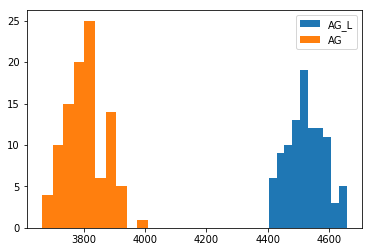

In [80]:
plt.hist(agl, label='AG_L')
plt.hist(ag, label='AG')
plt.legend()